In [1]:
import numpy as np
import torch 
import torchvision 
import matplotlib.pyplot as plt 

In [2]:
mnist_dev = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_test = torchvision.datasets.MNIST("./data", train=True, download=True)

In [3]:
x_dev = mnist_dev.data / 255
y_dev = mnist_dev.targets 

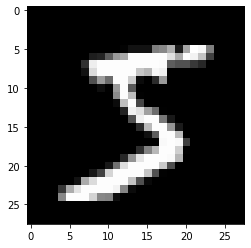

In [4]:
mnist_dev.data.shape 
x_dev.shape
y_dev.shape
plt.imshow(x_dev[0], cmap="gray")

In [5]:
n_train = 50000
n_val = 10000 
x_train, y_train = x_dev[:n_train].flatten(start_dim=1), y_dev[:n_train]
x_val, y_val = x_dev[n_train:].flatten(start_dim=1), y_dev[n_train:]

In [6]:
print(x_train.shape, x_val.shape)

torch.Size([50000, 784]) torch.Size([10000, 784])


In [7]:
num_features = 28 * 28 
num_classes = 10

weight = torch.empty(num_features, num_classes, requires_grad=False).uniform_(-1, 1) * np.sqrt(6 / (num_features + num_classes))
weight.requires_grad_()
bias = torch.zeros(num_classes, requires_grad=True)

In [8]:
def model(input):
    """
    Args:
        input: Tensor of features, shape (num_samples, num_features)
    Returns:
        logits: Tensor of logits, shape (num_samples, num_classes)
            logits[n, k] = log p(y_n = k | x_n)
    """
    # return torch.log_softmax(input @ weight + bias)
    return (input @ weight + bias).log_softmax(dim=1)

def log_softmax(input):
    return input - input.logsumexp(dim=1, keepdims=True)

def nll_loss(logits, targets):
    """
    Args:
        logits: Tensor of logits, shape (num_samples, num_classes)
            logits[n, k] = log p(y_n = k | x_n)
        targets: Correct class labels, shape (num_samples, )
    Returns:
        loss: Tensor, average loss for the batch of data, shape ()
    """
    return -logits[range(targets.shape[0]), targets].float().mean()

def get_accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean()

In [9]:
logits = torch.arange(9).reshape(3, 3)
targets = torch.tensor([2, 1, 0])
targets_one_hot = torch.zeros_like(logits)
targets_one_hot[range(targets.shape[0]), targets] = 1
print(targets_one_hot)
loss = nll_loss(logits, targets)
print(loss)

tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]])
tensor(-4.)


In [10]:
batch_size = 64
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train), y_train))


tensor(0.0781)
tensor(0.0673)


In [11]:
loss_fn = nll_loss

In [12]:
num_epochs = 2
learning_rate = 0.5
for epoch in range(num_epochs):
    for i in range(int(np.ceil((n_train / batch_size)))):
        # Get minibatch 
        start_i = i * batch_size
        end_i = min(start_i + batch_size, n_train)
        x_mini = x_train[start_i:end_i]
        y_mini = y_train[start_i:end_i]

        # Generate predictions
        logits = model(x_mini)

        # Compute the loss
        loss = loss_fn(logits, y_mini)

        # Compute the gradients of the loss w.r.t parameters (weight, bias)
        loss.backward()

        # Do gradient descent
        with torch.no_grad():
            weight -= learning_rate * weight.grad
            bias -= learning_rate * bias.grad
        weight.grad.zero_()
        bias.grad.zero_()
    print("Epoch {}:".format(epoch))
    print("loss_train: {}".format(loss))
    print("acc_train: {}".format(get_accuracy(model(x_train), y_train)))

Epoch 0:
loss_train: 0.40359678864479065
acc_train: 0.9051399827003479
Epoch 1:
loss_train: 0.3132064938545227
acc_train: 0.9135199785232544


# using torch.nn.functional

In [13]:
import torch.nn.functional as F

In [14]:
def model(input):
    return input @ weight + bias

loss_fn = F.cross_entropy

In [15]:
loss = loss_fn(model(x_train[:batch_size]), y_train[:batch_size])
print(loss)

tensor(0.2299, grad_fn=<NllLossBackward>)


# using nn.Module

In [16]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        # no need to set require_grad = True
        self.weight = nn.Parameter(torch.empty(num_features, num_classes).uniform_(-1, 1) 
                            * np.sqrt(6 / (num_features + num_classes)))
        self.bias = nn.Parameter(torch.zeros(num_classes))

    def forward(self, input):
        return input @ self.weight + self.bias

In [17]:
model = Net(num_features, num_classes)
print(loss_fn(model(x_train), y_train))

tensor(2.3475, grad_fn=<NllLossBackward>)


In [26]:
num_epochs = 2
learning_rate = 0.5
def fit(model, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil((n_train / batch_size)))):
            # Get minibatch 
            start_i = i * batch_size
            end_i = min(start_i + batch_size, n_train)
            x_mini = x_train[start_i:end_i]
            y_mini = y_train[start_i:end_i]

            # Generate predictions
            logits = model(x_mini)

            # Compute the loss
            loss = loss_fn(logits, y_mini)

            # Compute the gradients of the loss w.r.t parameters (weight, bias)
            model.zero_grad()
            loss.backward()

            # Do gradient descent
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
    
        print("Epoch {}:".format(epoch))
        print("loss_train: {}".format(loss))
        print("acc_train: {}".format(get_accuracy(model(x_train), y_train)))

In [27]:
fit(model=model, num_epochs=2)

Epoch 0:
loss_train: 0.26737791299819946
acc_train: 0.9166799783706665
Epoch 1:
loss_train: 0.239226296544075
acc_train: 0.9184799790382385


# using nn.Linear

In [29]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lin = nn.Linear(num_features, num_classes)
    
    def forward(self, input):
        return self.lin(input)

def initialize_weight(model):
    if isinstance(model, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(model.weight)

In [30]:
model = Net(num_features, num_classes)
model.apply(initialize_weight)

fit(model, num_epochs=2)

Epoch 0:
loss_train: 0.4025786519050598
acc_train: 0.90420001745224
Epoch 1:
loss_train: 0.31374311447143555
acc_train: 0.9128599762916565


# using torch.optim

In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
num_epochs = 2
learning_rate = 0.5
def fit(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil((n_train / batch_size)))):
            # Get minibatch 
            start_i = i * batch_size
            end_i = min(start_i + batch_size, n_train)
            x_mini = x_train[start_i:end_i]
            y_mini = y_train[start_i:end_i]

            # Generate predictions
            logits = model(x_mini)

            # Compute the loss
            loss = loss_fn(logits, y_mini)

            # Compute the gradients of the loss w.r.t parameters (weight, bias)
            model.zero_grad()
            loss.backward()

            # Do gradient descent
            optimizer.step()
    
        print("Epoch {}:".format(epoch))
        print("loss_train: {}".format(loss))
        print("acc_train: {}".format(get_accuracy(model(x_train), y_train)))

In [34]:
fit(model, optimizer, 2)

Epoch 0:
loss_train: 0.2701719105243683
acc_train: 0.9164800047874451
Epoch 1:
loss_train: 0.24144691228866577
acc_train: 0.9181600213050842


# using Dataset

In [40]:
from torch.utils.data.dataset import TensorDataset

train_set = TensorDataset(x_train, y_train)

In [41]:
num_epochs = 2
learning_rate = 0.5
def fit(model, optimizer, train_set, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil((n_train / batch_size)))):
            # Get minibatch 
            start_i = i * batch_size
            end_i = min(start_i + batch_size, n_train)
            # x_mini = x_train[start_i:end_i]
            # y_mini = y_train[start_i:end_i]
            x_mini, y_mini = train_set[start_i:end_i]

            # Generate predictions
            logits = model(x_mini)

            # Compute the loss
            loss = loss_fn(logits, y_mini)

            # Compute the gradients of the loss w.r.t parameters (weight, bias)
            model.zero_grad()
            loss.backward()

            # Do gradient descent
            optimizer.step()
    
        print("Epoch {}:".format(epoch))
        print("loss_train: {}".format(loss))
        print("acc_train: {}".format(get_accuracy(model(x_train), y_train)))

In [42]:
model = Net(num_features, num_classes)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, train_set, 2)

Epoch 0:
loss_train: 0.40804043412208557
acc_train: 0.9044600129127502
Epoch 1:
loss_train: 0.3180721402168274
acc_train: 0.9131600260734558


# using dataloader

In [43]:
from torch.utils.data.dataloader import DataLoader

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [44]:
num_epochs = 2
learning_rate = 0.5
def fit(model, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        for (x_mini, y_mini) in train_loader:
            # Generate predictions
            logits = model(x_mini)

            # Compute the loss
            loss = loss_fn(logits, y_mini)

            # Compute the gradients of the loss w.r.t parameters (weight, bias)
            model.zero_grad()
            loss.backward()

            # Do gradient descent
            optimizer.step()
    
        print("Epoch {}:".format(epoch))
        print("loss_train: {}".format(loss))
        print("acc_train: {}".format(get_accuracy(model(x_train), y_train)))

In [45]:
model = Net(num_features, num_classes)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, train_loader, 2)

Epoch 0:
loss_train: 1.202134132385254
acc_train: 0.8512799739837646
Epoch 1:
loss_train: 0.2358727604150772
acc_train: 0.9149600267410278


# validation

In [46]:
train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)

dataloaders = {}
dataloaders["train"] = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dataloaders["val"] = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [49]:
num_epochs = 2
learning_rate = 0.5
def fit(model, optimizer, dataloaders, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for (x_mini, y_mini) in dataloaders["train"]:
            # Generate predictions
            logits = model(x_mini)

            # Compute the loss
            loss = loss_fn(logits, y_mini)

            # Compute the gradients of the loss w.r.t parameters (weight, bias)
            model.zero_grad()
            loss.backward()

            # Do gradient descent
            optimizer.step()

        model.eval()
        loss_val = 0
        with torch.no_grad():
            for (x_mini, y_mini) in dataloaders["val"]:
                logits = model(x_mini)

                loss_val += loss_fn(logits, y_mini)
            avg_loss = loss_val / len(dataloaders["val"])
    
        print("Epoch {}:".format(epoch))
        print("loss_train: {}".format(loss))
        print("loss_val: {}".format(avg_loss))

In [50]:
model = Net(num_features, num_classes)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, dataloaders, 2)

Epoch 0:
loss_train: 0.3111090362071991
loss_val: 0.36481213569641113
Epoch 1:
loss_train: 0.14805105328559875
loss_val: 0.2823346257209778
